# Extensions of the Hodgkin-Huxley Model
Taken from Dayan (2006): *Theoretical Neuroscience* (Ch. 6).


## Hodgkin-Huxley
Traditionally, the Hodgkin-Huxley model is formulated as:

> $ I = C_m \frac{dV}{dt} + g_{Na}m^3h(V - V_{Na}) - g_Kn^4(V-V_K)-g_L(V-V_L) $

> $\frac{dn}{dt} = \alpha_n(V)(1-n)-\beta_n(V)(n) $

> $\frac{dm}{dt} = \alpha_m(V)(1-m)-\beta_m(V)(m) $

> $\frac{dh}{dt} = \alpha_h(V)(1-h)-\beta_h(V)(h) $

where

> $ \alpha_m = \frac{0.38(V + 29.7)}{1 - exp(-0.1[V+29.7])}, \ \beta_m = 15.2 \cdot exp(-0.0556(V + 54.7))$

> $ \alpha_h = 0.266 \cdot exp(-0.05(V+48)), \ \beta_h = 3.8 / (1 + exp(-0.1(V+18))$

> $ \alpha_n = \frac{0.02(V + 45.7)}{1 - exp(-0.1[V+45.7])}, \ \beta_n = 0.25 \cdot exp(-0.0125(V + 55.7))$

## Connor-Stevens

In the Connor-Stevens model, however, additional transient $K^+$ conductance is added, i.e. the **A-current**:

> $ I = C_m \frac{dV}{dt} + g_{Na}m^3h(V - V_{Na}) - g_Kn^4(V-V_K)-g_L(V-V_L) + g_A a^3 b (V - V_A) $

where the A-current is described directly in terms of the asymptotic values and $\tau$ functions for its gating variables:

> $ a_{\infty} = (\frac{0.0761 \cdot exp(0.0314(V + 94.22))}{1 + exp(0.0346(V + 1.17))})^\frac{1}{3} $

> $ \tau_a = 0.3632 + 1.158 / (1 + exp(0.0497(V + 55.96))) $

> $ b_{\infty} = (\frac{1}{1 + exp(0.0688(V+53.3))})^4 $

> $ \tau_b = 1.25 + 2.678/(1 + exp(0.0624(V+50))) $

The constants are defined as:


> $g_{Na}$ = 120, $V_{Na}$ = 55

> $g_K$ = 20, $V_K$ = -72

> $g_A$ = 47.7, $V_K$ = -75

> $g_L$ = 0.3, $V_L$ = -17

> $C$ = 1



In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Here we define all of the functions necessary
## for simulating the Connor-Stevens neuron. 
## Below we run simulations for the CS neuron under 
## different conditions.

def alpha_m(V):
    return (0.38 * (V + 29.7)) / (1 - np.exp(-0.1*(V+29.7)))

def beta_m(V):
    return 15.2 * np.exp(-0.0556*(V+54.7))

def alpha_h(V):
    return 0.266 * np.exp(-0.05*(V+48))

def beta_h(V):
    return 3.8 / (1 + np.exp(-0.1*(V+18)))

def alpha_n(V):
    return (0.02 * (V + 45.7)) / (1 - np.exp(-0.1*(V+45.7)))

def beta_n(V):
    return 0.25 * np.exp(-0.0125*(V + 55.7))

def a_inf(V):
    return ( (0.0761 * np.exp(0.0314 * (V+94.22))) / (1 + np.exp(0.0346 * (V+1.17))) ) ** (1/3)

def tau_a(V):
    return 0.3632 + 1.158/(1 + np.exp(0.0497 * (V+55.96)))

def b_inf(V):
    return (1 / (1 + np.exp(0.0688 * (V+53.3))))**4

def tau_b(V):
    return 1.24 + 2.678 / (1 + np.exp(0.0624 * (V+50)))

def I_Na(V, m, h, g_Na=120, V_Na=55):
    return g_Na * m**3 * h * (V - V_Na)

def I_K(V, n, g_K=20, V_K=-72):
    return g_K * n**4 * (V - V_K)

def I_A(V, a, b, g_A=47.7, V_A=-75):
    return g_A * a**3 * b * (V - V_A)

def I_L(V, g_L=0.3, V_L=-17):
    return g_L * (V - V_L)

def dALLdt(V, m, h, n, a, b, I, C, g_Na, V_Na, g_K, V_K, g_A, V_A, g_L, V_L):
    dVdt = I - I_Na(V, m, h, g_Na, V_Na) - I_K(V, n, g_K, V_K) - I_A(V, a, b, g_A, V_A) - I_L(V, g_L, V_L) / C
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dadt = (a_inf(V) - a)/tau_a(V)
    dbdt = (b_inf(V) - b)/tau_b(V)
    return dVdt, dmdt, dhdt, dndt, dadt, dbdt
    
def connor_stevens(t, I, x0, C=1, g_Na=120, V_Na=55, g_K=20, V_K=-72, 
                   g_A=47.7, V_A=-75, g_L=0.3, V_L=-17):
    '''Function for the Connor-Stevens neuron
    
    INPUTS
    - t: times (ms), 1d array
    - I: current (A), 1d array
    - x0: initial conditions of [V, m, h, n]
    '''
    
    ## Preallocate space and initialize arrays.
    X = np.zeros((len(x0), t.size))
    X[:,0] = x0
    V, m, h, n, a, b = X
    
    ## Main loop.
    dt = np.diff(t)
    for i in np.arange(1, t.size):
        
        ## Compute updates.
        dVdt, dmdt, dhdt, dndt, dadt, dbdt = dALLdt(V[i-1], m[i-1], h[i-1], n[i-1], a[i-1], b[i-1],
                                                    I[i-1], g_Na=g_Na, V_Na=V_Na, g_K=g_K, V_K=V_K,
                                                    g_A=g_A, V_A=V_A, g_L=g_L, V_L=V_L, C=C)
    
        ## Update values.
        V[i] = V[i-1] + dVdt * dt[i-1]
        m[i] = m[i-1] + dmdt * dt[i-1]
        h[i] = h[i-1] + dhdt * dt[i-1]
        n[i] = n[i-1] + dndt * dt[i-1]
        a[i] = a[i-1] + dadt * dt[i-1]
        b[i] = b[i-1] + dbdt * dt[i-1]
        
    return V, m, h, n, a, b

#### Part 1b: Constant Current
We demonstrate the dynamics of the Hodgkin-Huxley neuron at $I$ = 20 $\frac{\mu A}{cm^2}$.

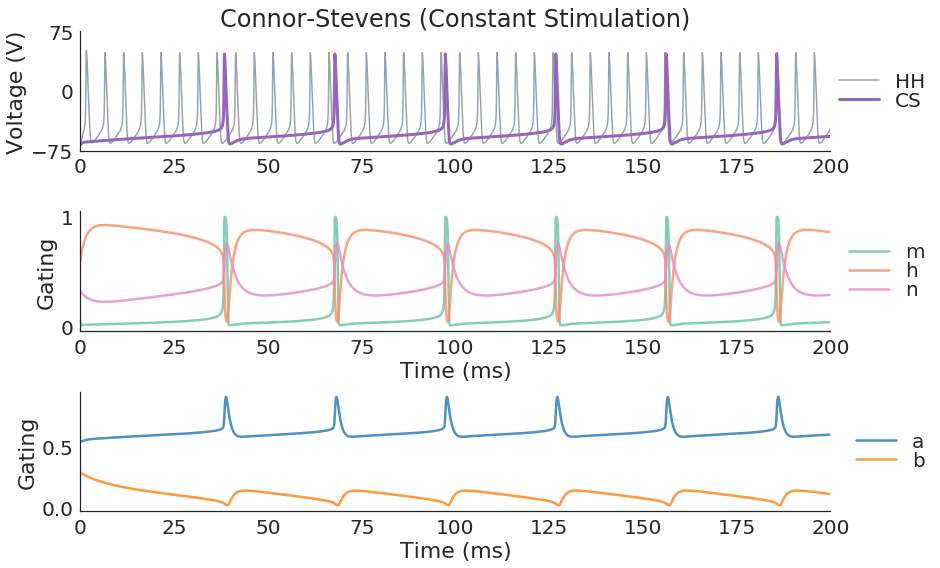

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define timing paramters (ms).
dt = 0.01
t = np.arange(0,200+dt,dt)

## Define stimulation.
I = np.ones_like(t) * 10

## Define initial conditions.
x0 = [-68, 0.05, 0.6, 0.32, 0.54, 0.28] # [V, m, h, n]
C = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Run Simulation.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Connor-Stevens model.
V_CS, m, h, n, a, b = connor_stevens(t, I, x0)

## When g_A = 0, equivalent to Hodgkin-Huxley.
V_HH, _, _, _, _, _ = connor_stevens(t, I, x0, g_A=0)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(12,8),sharex=True)

## Plot voltage.
axes[0].plot(t, V_HH, color='#34495e', linewidth=1.5, alpha=0.5, label='HH')
axes[0].plot(t, V_CS, color='#9467bd', linewidth=3, label='CS')
axes[0].set(xlim=(t.min(), t.max()), yticks=[-75,0,75],ylabel='Voltage (V)',
            title='Connor-Stevens (Constant Stimulation)')
axes[0].legend(loc=7, bbox_to_anchor=(1.15,0.5), labelspacing=0)

## Plot gating variables.
axes[1].plot(t, m, label='m', color='#66c2a5', alpha=0.8, linewidth=2.5)
axes[1].plot(t, h, label='h', color='#fc8d62', alpha=0.8, linewidth=2.5)
axes[1].plot(t, n, label='n', color='#e78ac3', alpha=0.8, linewidth=2.5)
axes[1].set(xlabel='Time (ms)', ylabel='Gating')
axes[1].legend(loc=7, bbox_to_anchor=(1.15,0.5), labelspacing=0)

## Plot gating variables.
axes[2].plot(t, a, label='a', alpha=0.8, linewidth=2.5)
axes[2].plot(t, b, label='b', alpha=0.8, linewidth=2.5)
axes[2].set(xlabel='Time (ms)', ylabel='Gating')
axes[2].legend(loc=7, bbox_to_anchor=(1.15,0.5), labelspacing=0)

sns.despine()
plt.tight_layout()